In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as st
import seaborn as sns

import pingouin as pg
import hyppo as hp

from statsmodels.distributions.empirical_distribution import ECDF

matplotlib.style.use('ggplot')

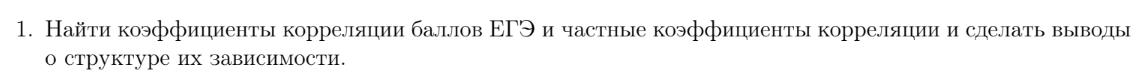

In [57]:
#для каждой оценки составим свою выборку
data = pd.read_csv('4_set.csv')
data = data.dropna()

#Посчитаем попарыне коэффиценты корр.
print("К-фы корреляции: ")
print(data.corr())

print("\nЧастные: ")
print(data.pcorr())

К-фы корреляции: 
          Оценка.1  Оценка.2  Оценка.3  Оценка.4
Оценка.1  1.000000  0.511660  0.432463  0.123863
Оценка.2  0.511660  1.000000  0.436438  0.226106
Оценка.3  0.432463  0.436438  1.000000  0.255122
Оценка.4  0.123863  0.226106  0.255122  1.000000

Частные: 
          Оценка.1  Оценка.2  Оценка.3  Оценка.4
Оценка.1  1.000000  0.399542  0.273219 -0.040675
Оценка.2  0.399542  1.000000  0.245450  0.137080
Оценка.3  0.273219  0.245450  1.000000  0.182677
Оценка.4 -0.040675  0.137080  0.182677  1.000000


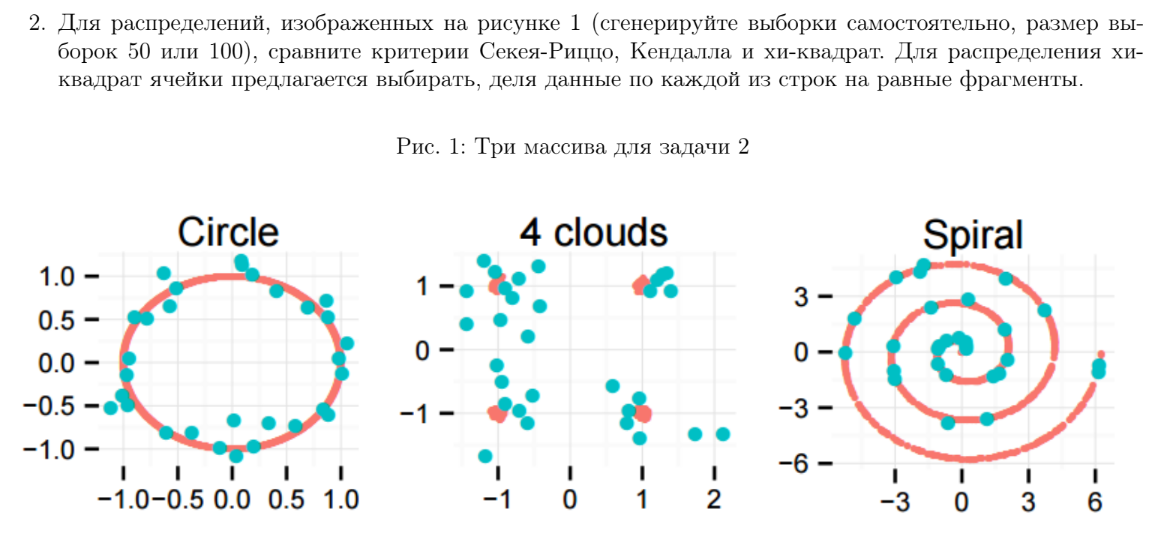

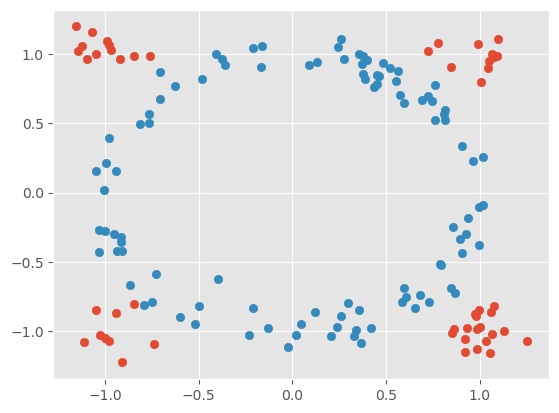

In [16]:
def circle_dist(size):
    Phi = st.uniform.rvs(loc=0, scale=2*np.pi, size=size)
    X = np.cos(Phi) + st.norm(0, 0.07).rvs(size=size)
    Y = np.sin(Phi) + st.norm(0, 0.07).rvs(size=size)
    return [X, Y]
    
def point_dist(size):
    Points = np.random.randint(0, 4, size=size)
    X = []
    Y = []
    for p in Points:
        if p == 0:
            X.append(-1)
            Y.append(-1)
        elif p == 1:
            X.append(-1)
            Y.append(1)
        elif p == 2:
            X.append(1)
            Y.append(1)
        else:
            X.append(1)
            Y.append(-1)
    X = np.array(X) + st.norm(0, 0.1).rvs(size=size)
    Y = np.array(Y) + st.norm(0, 0.1).rvs(size=size)
    return [X, Y]

def spiral_dist(size):
    base = st.uniform.rvs(size=size)
    psi = 6*np.pi*(-(1-base**1.5)**(2/3) + 1)
    X = psi/3*np.cos(psi) + st.norm(0, 0.05).rvs(size=size)
    Y = psi/3*np.sin(psi) + st.norm(0, 0.05).rvs(size=size)
    return [X, Y]


sample = point_dist(50)
plt.scatter(sample[0], sample[1])
sample = circle_dist(100)
plt.scatter(sample[0], sample[1])

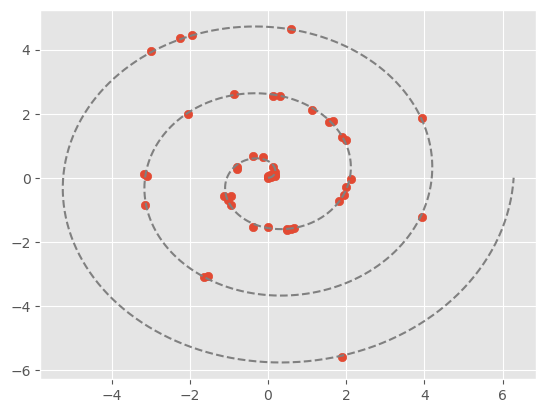

In [12]:
sample = spiral_dist(50)
plt.scatter(sample[0], sample[1])

t = np.linspace(0,6*np.pi, 1000)
x = t/3*np.cos(t)
y = t/3*np.sin(t)

plt.plot(x, y, '--', color='gray')

In [74]:
def chi2_pval(X, Y, n):
    k = round(n**0.2) #кол-во ячеек, считаем, что k делит sizes[i]
    m = 2
    n = int(n/k)*k
    X = X[:n]
    Y = Y[:n]
    data = [X, Y]

    sample = np.concatenate(data)
    sample = np.sort(sample)
    quant = [] #считаем, что помимо этого у нас есть -inft и +inft
    for i in range(1, k):
        quant.append(sample[int(i*m*n/k)])

    freq = []
    for i in range(2):
        curr_freq = np.zeros(k)
        sample = data[i]
        for elem in sample:
            for j in range(k-1):
                if j == 0:
                    if elem <= quant[j]:
                        curr_freq[j] += 1
                        break
                else:
                    if quant[j-1] < elem <= quant[j]:
                        curr_freq[j] += 1
                        break
                if j == k-2:
                    curr_freq[k-1] += 1
        freq.append(curr_freq)

    #статистика Пирсона
    stat = 0
    for j in range(k):
        
        sum_freq_i = 0
        for i in range(m):
            sum_freq_i += freq[i][j]
            
        for i in range(m):
            
            sum_freq_j = 0
            for p in range(k):
                sum_freq_j += freq[i][p]
                
            tmp = (freq[i][j] - (sum_freq_i/n/m * sum_freq_j))**2
            tmp /= (sum_freq_i/n/m * sum_freq_j)
            stat += tmp
            
    return 1-st.chi2.cdf(stat, df=(m-1)*(k-1))

In [70]:
def pval_plot(func, n):
    kendall = []
    dcorr = []
    chi = []
    
    for i in range(300):
        sample = func(n)
        X = sample[0]
        Y = sample[1]
        
        dcorr.append(hp.independence.Dcorr().test(x=X, y=Y)[1])
        kendall.append(st.kendalltau(x=X, y=Y).pvalue)
        chi.append(chi2_pval(X, Y, n))
    
    t = np.linspace(0, 1, 300)
    plt.plot(np.sort(kendall), t, label='k')
    plt.plot(np.sort(dcorr), t, label='d')
    plt.plot(np.sort(chi), t, label='c')
    plt.legend() 
    


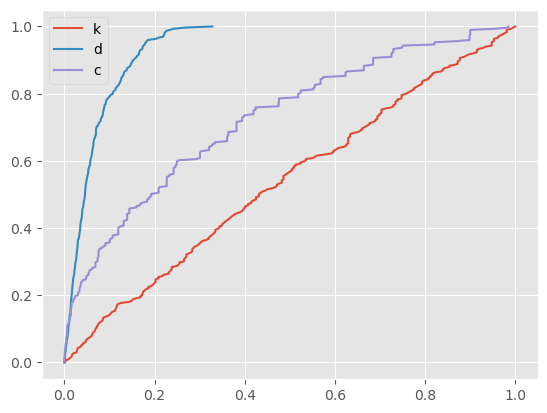

In [76]:
pval_plot(spiral_dist, 100)

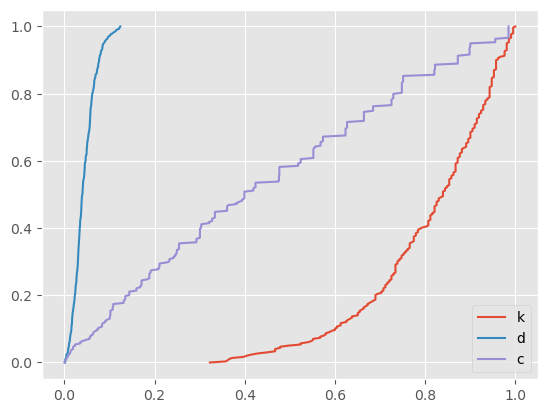

In [78]:
pval_plot(circle_dist, 100)

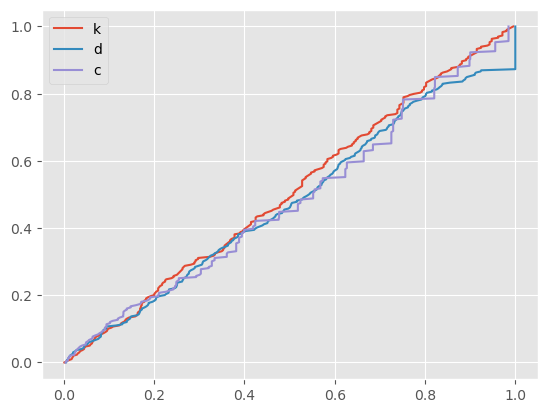

In [80]:
pval_plot(point_dist, 100)

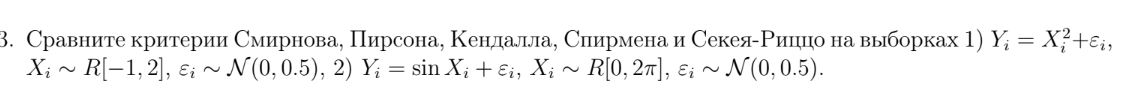

In [6]:
def smirnov_func(X, Y, point, n):
    H = 0
    F = 0
    G = 0
    
    x = point[0]
    y = point[1]
    
    for i in range(n):
        if X[i] <= x and Y[i] <= y:
            H += 1
        if X[i] <= x:
            F += 1
        if Y[i] <= y:
            G += 1
        
    return n**0.5*np.abs(H/n - F/n*G/n)

def smirnov_val(X, Y, n):
    point = sc.optimize.minimize(lambda params: -smirnov_func(X, Y, params, n), x0 = (np.mean(X), np.mean(Y))).x
    return smirnov_func(X, Y, point, n)

def counter(val):
    f = open('quantiles/smirnov_independence.txt', 'r')
    data = f.read()
    data = data.split(" ")
    count = 0
    while float(data[count]) <= val:
        count += 1
        if count >= len(data)-1:
            break
    count /= len(data)
    return count

In [21]:
#генерация квантилей!
f = open('quantiles/smirnov_independence.txt', 'w')

table = []
for i in range(1000):
    sample1 = sc.stats.norm.rvs(0, 1, size=300)
    sample2 = sc.stats.norm.rvs(0, 1, size=300)
    val = smirnov_val(sample1, sample2, 300)
    table.append(val)
    
table = np.array(table)
table = np.sort(table)

for i in range(len(table)):
    f.write(str(table[i]) + ' ')
    
f.close()

In [37]:
print(table)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.84900179e-04 5.77350269e-04 9.62250449e-04 1.53960072e-03
 1.73205081e-03 1.73205081e-03 1.73205081e-03 1.73205081e-03
 1.92450090e-03 2.30940108e-03 2.30940108e-03 2.30940108e-03
 2.30940108e-03 2.30940108e-03 2.30940108e-03 2.30940108e-03
 2.30940108e-03 2.88675135e-03 3.07920144e-03 3.07920144e-03
 3.07920144e-03 3.27165153e-03 3.46410162e-03 3.46410162e-03
 3.84900179e-03 3.84900179e-03 3.84900179e-03 4.04145188e-03
 4.04145188e-03 4.23390197e-03 4.23390197e-03 4.23390197e-03
 4.61880215e-03 4.61880215e-03 4.61880215e-03 4.81125224e-03
 4.81125224e-03 5.19615242e-03 5.38860251e-03 5.77350269e-03
 5.77350269e-03 5.77350269e-03 5.77350269e-03 5.77350269e-03
 5.96595278e-03 6.15840287e-03 6.35085296e-03 6.73575314e-03
 6.92820323e-03 6.92820323e-03 7.31310341e-03 7.50555350e-03
 7.69800359e-03 7.69800359e-03 8.08290377e-03 8.08290377e-03
 8.08290377e-03 8.082903

In [33]:
def pval_plot(dist, func, n):
    smirnov = []
    dcorr = []
    kendall = []
    pearson = []
    spearman = []
    
    
    for i in range(300):
        sample1 = dist.rvs(size=n)
        sample2 = func(sample1, n)
        
        smirnov.append(1 - counter(smirnov_val(sample1, sample2, n)))
        dcorr.append(hp.independence.Dcorr().test(x=sample1, y=sample2)[1])
        kendall.append(st.kendalltau(x=sample1, y=sample2).pvalue)
        pearson.append(st.pearsonr(x=sample1, y=sample2).pvalue)
        spearman.append(st.spearmanr(sample1, sample2).pvalue)
        
    t = np.linspace(0, 1, 300)
    plt.plot(np.sort(smirnov), t, label='s')
    plt.plot(np.sort(dcorr), t, label='dcorr')
    plt.plot(np.sort(kendall), t, label='kendall')
    plt.plot(np.sort(pearson), t, label='pear')
    plt.plot(np.sort(spearman), t, label='sp')
    
    plt.legend() 
    
def func1(sample, n):
    return sample**2 + st.norm(0, 0.5).rvs(size=n)

def func2(sample, n):
    return np.sin(sample) + st.norm(0, 0.5).rvs(size=n)

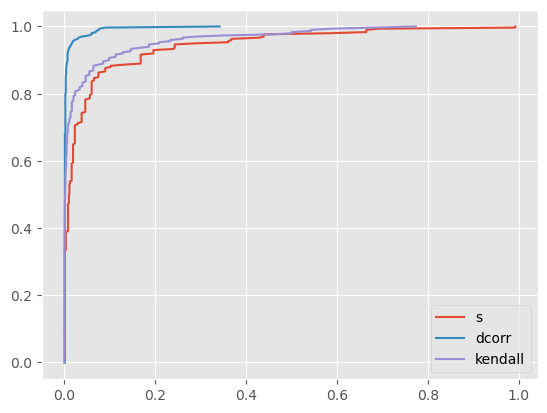

In [25]:
n = 20
pval_plot(st.uniform(loc=-1, scale=3), func1, n)

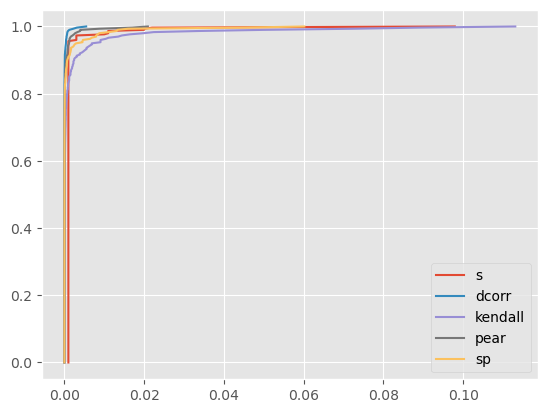

In [35]:
n = 40
pval_plot(st.uniform(loc=0, scale=2*np.pi), func2, n)

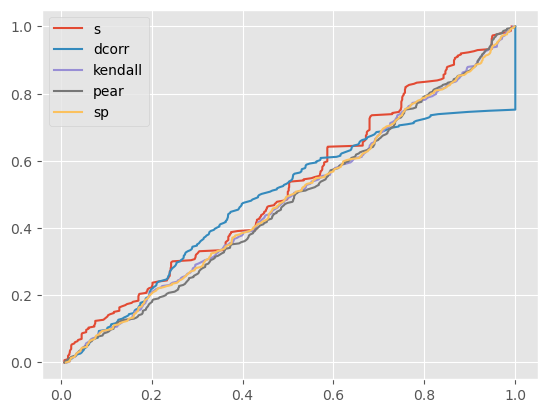

In [8]:
def pval_plot(n):
    smirnov = []
    dcorr = []
    kendall = []
    pearson = []
    spearman = []
    
    for i in range(300):
        sample1 = st.norm(0, 1).rvs(size=n)
        sample2 = st.norm(0, 2).rvs(size=n)
        smirnov.append(1 - counter(smirnov_val(sample1, sample2, n)))
        dcorr.append(hp.independence.Dcorr().test(x=sample1, y=sample2)[1])
        kendall.append(st.kendalltau(x=sample1, y=sample2).pvalue)
        pearson.append(st.pearsonr(x=sample1, y=sample2).pvalue)
        spearman.append(st.spearmanr(sample1, sample2).pvalue)
        
        
    t = np.linspace(0, 1, 300)
    plt.plot(np.sort(smirnov), t, label='s')
    plt.plot(np.sort(dcorr), t, label='dcorr')
    plt.plot(np.sort(kendall), t, label='kendall')
    plt.plot(np.sort(pearson), t, label='pear')
    plt.plot(np.sort(spearman), t, label='sp')
    
    plt.legend()
    
n = 1000
pval_plot(n)